In [1]:
import os

if not os.path.exists('Output/'):
    raise Exception("Models not found, pls run 'Train' first.")

In [2]:
from keras.preprocessing.image import ImageDataGenerator

test_gen = ImageDataGenerator(rescale=1./255)

test_gen_output = test_gen.flow_from_directory('data_set/test', target_size=(256, 256), 
                                            batch_size=536, class_mode='binary')

2023-10-08 16:09:47.328182: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 536 images belonging to 2 classes.


In [3]:
x_test = []
y_test = []
for x, y in test_gen_output:
    x_test = x
    y_test = y
    break

# EvaluationVisualization

In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay

def show_confusion_matrix(conf_matrix):
    ConfusionMatrixDisplay(conf_matrix, display_labels=['COVID','NORMAL']).plot()

In [6]:
def show_performance_graph(label, accuracy, precision, recall, f1):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title(label + " Summary")
    bar_values = list(map(lambda x: x * 100, [accuracy, precision, recall, f1]))
    ax.bar(['Accuracy', 'Precision', 'Recall', 'F1 Score'], bar_values, 0.35)
    ax.set_xlabel('Model evaluation metrics', fontweight ='bold', fontsize = 15)
    ax.set_ylabel('Percentage', fontweight ='bold', fontsize = 15)
    
    for i in range(len(bar_values)):
        plt.text(i, bar_values[i] + 1, str(round(bar_values[i], 2)) + '%')
    
    plt.show()

In [7]:
from tensorflow.keras.preprocessing import image
import numpy as np

def get_single_image(path):
    img_path = path
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    return img_array

In [8]:
import matplotlib.image as mpimg

def print_image(title, path):
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.title(title)
    plt.show()

# ModelEvaluateFunction

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import time

def evaluate(label, model):
    print('\n*****************',label, '*****************\n')
    model.summary()
    
    result = model.predict(x_test)
    
    y_pred = []
    for i in result.flatten():
        if i >= 0.5:
            y_pred.append(1) 
        else:
            y_pred.append(0) 
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    print('TP :', tp, ', TN :', tn,', FP :', fp,', FN :', fn)
    show_confusion_matrix(conf_matrix)
    
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy :', accuracy)
    
    precision = precision_score(y_test, y_pred, average = "macro")
    print('Precision :', precision)
    
    recall = recall_score(y_test, y_pred, average = "macro")
    print('Recall :', recall)
    
    f1 = f1_score(y_test, y_pred, average = "macro")
    print('F1 score :', f1)
    
    show_performance_graph(label, accuracy, precision, recall, f1)
    
    non_covid_img_path = 'images/non/patient01217-study2-view1_frontal.jpg'
    predict_timer = time.time()
    single_non_covid_predict_result = model.predict(get_single_image(non_covid_img_path))
    predict_time_sec = (float((time.time()-predict_timer)))
    if single_non_covid_predict_result >= 0.5:
        print_image(('NON-Covid Sample - Predicted in ' + str(predict_time_sec) + ' Sec'), non_covid_img_path)
    else:
        print("Predicted wrongly. Expected 'NON-Covid', but predicted 'COVID'") 
        
    covid_img_path = 'images/covid/1.jpg'
    predict_timer = time.time()
    single_covid_predict_result = model.predict(get_single_image(covid_img_path))
    predict_time_sec = (float((time.time()-predict_timer)))
    if single_covid_predict_result >= 0.5:
        print("Predicted wrongly. Expected 'Covid', but predicted 'NON-COVID'") 
    else:
        print_image(('Covid Sample - Predicted in ' + str(predict_time_sec) + ' Sec'), covid_img_path)
        
    return accuracy, precision, recall, f1, predict_time_sec

In [10]:
models_accuracy = {}
models_precision = {}
models_recall = {}
models_f1 = {}
models_predict_time = {}

In [11]:
from tensorflow.keras.models import load_model


***************** Scratch model *****************

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 85, 85, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 den

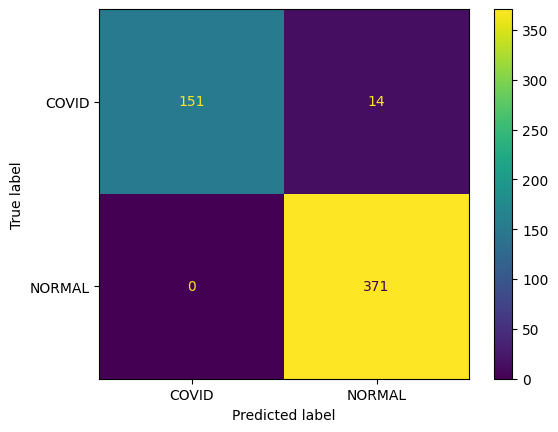

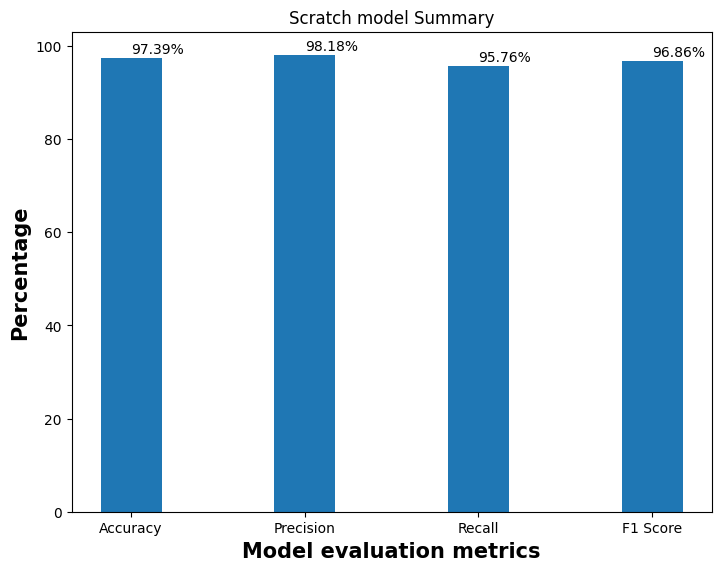

1/1 [==============================] - 0s 22ms/step


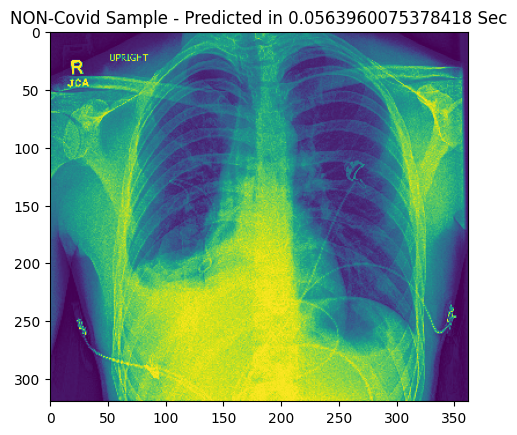

1/1 [==============================] - 0s 21ms/step


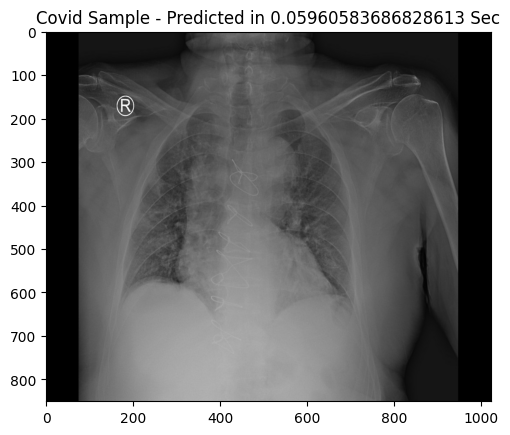

In [12]:
label = 'Scratch model'
models_accuracy[label], models_precision[label], models_recall[label], models_f1[label], models_predict_time[label]  = evaluate(label, load_model('Output/ScratchModel.h5'))


***************** Resnet model *****************

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 58,602,241
Trainable params: 58,458,497
Non-trainable par

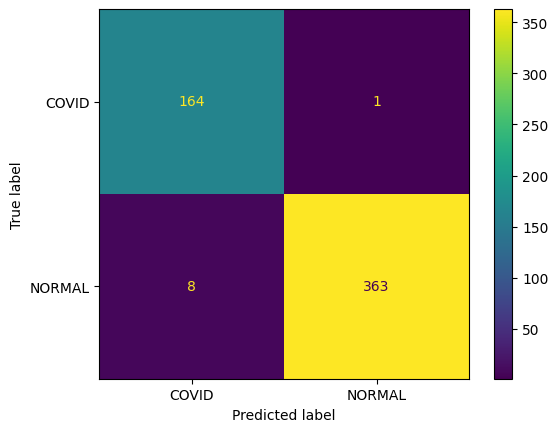

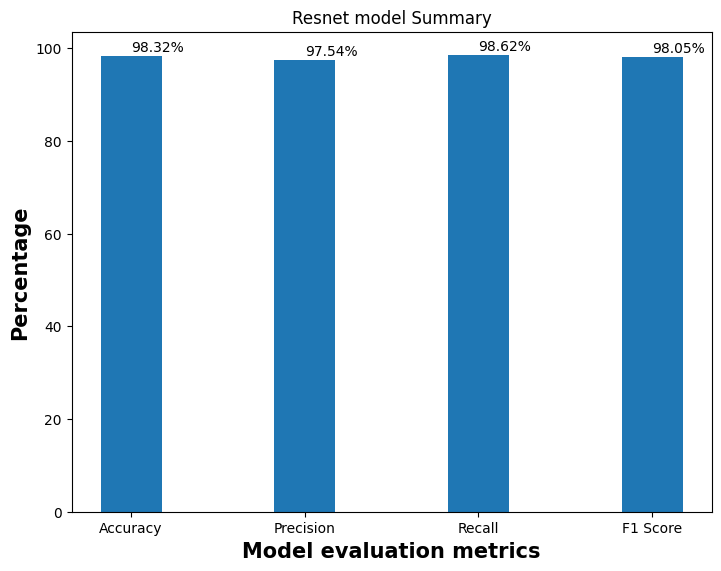

1/1 [==============================] - 0s 267ms/step


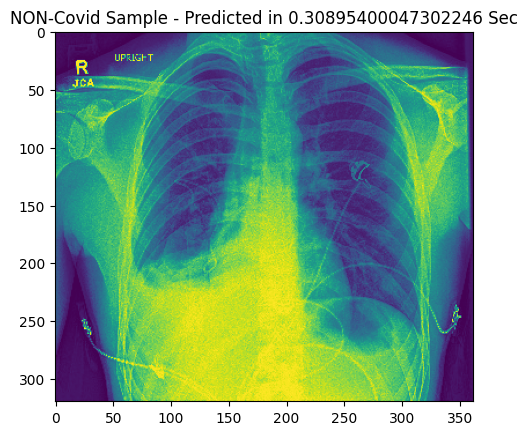

1/1 [==============================] - 0s 260ms/step


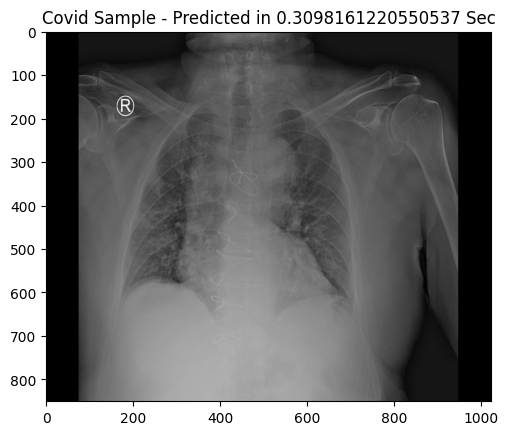

In [13]:
label = 'Resnet model'
models_accuracy[label], models_precision[label], models_recall[label], models_f1[label], models_predict_time[label] = evaluate(label, load_model('Output/ResnetModel.h5'))


***************** Xception model *****************

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21,132,073
Trainable params: 21,077,545
Non-trainable p

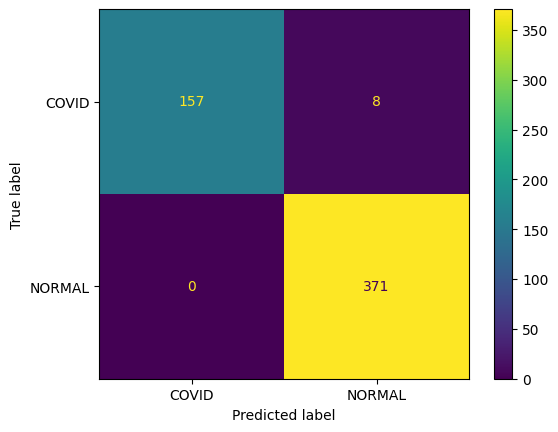

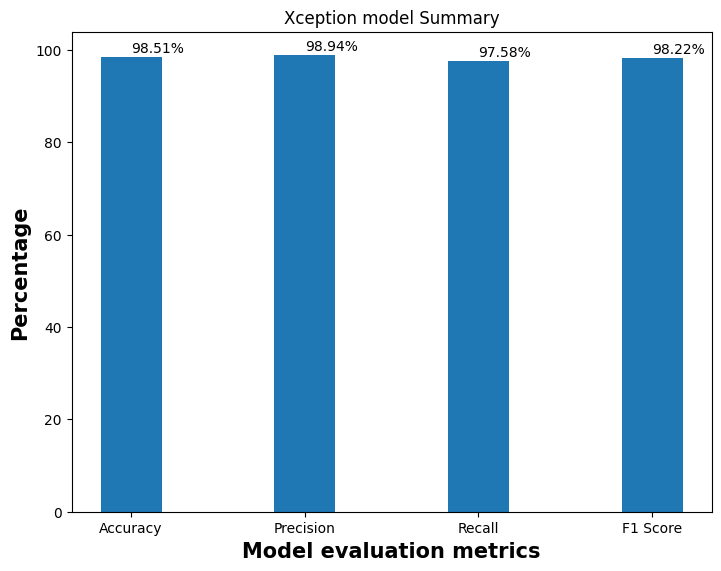

1/1 [==============================] - 0s 105ms/step


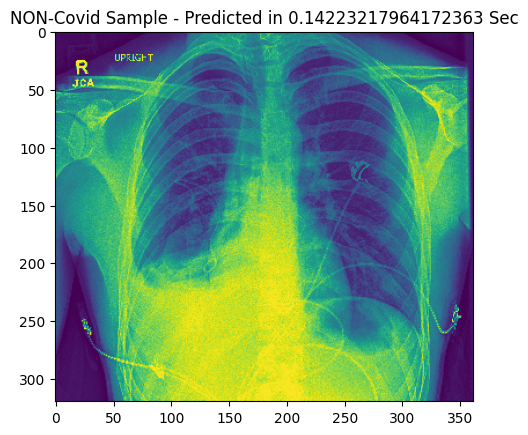

1/1 [==============================] - 0s 105ms/step


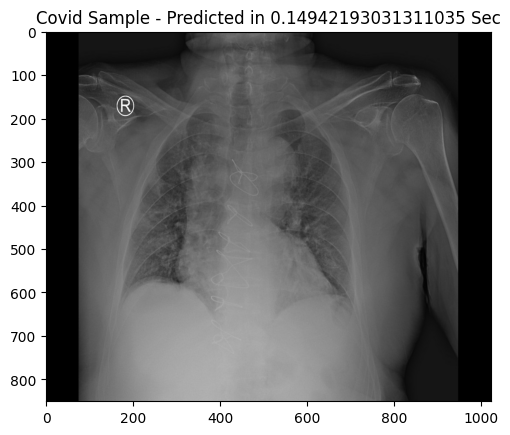

In [14]:
label = 'Xception model'
models_accuracy[label], models_precision[label], models_recall[label], models_f1[label], models_predict_time[label] = evaluate(label, load_model('Output/XceptionModel.h5'))

# Model comparison

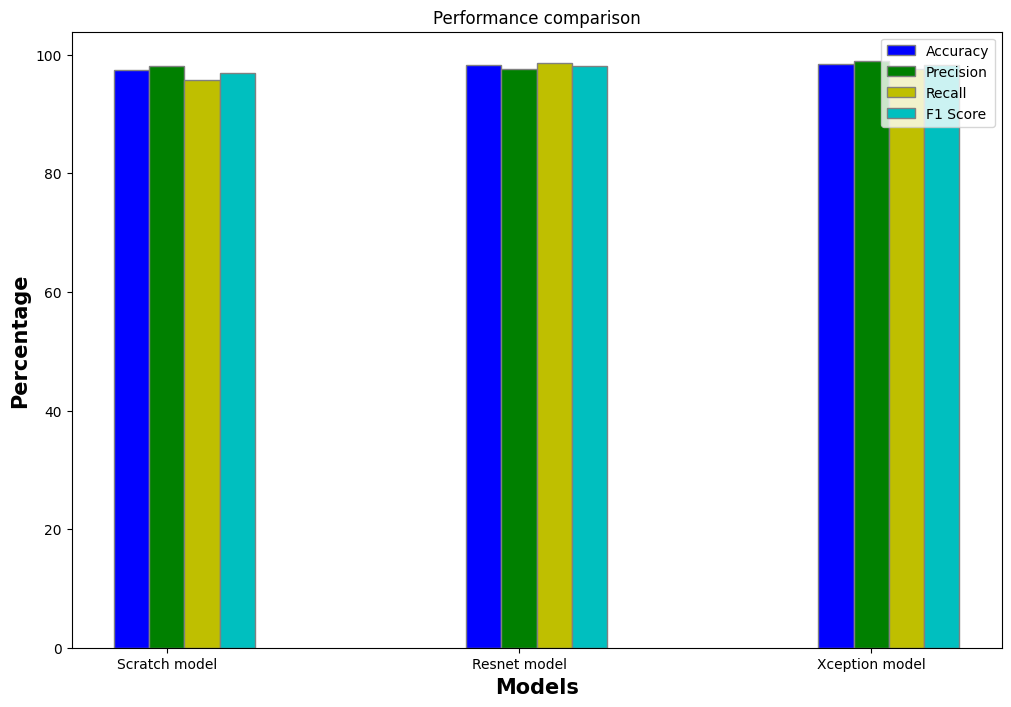

In [15]:
accuracies = list(map(lambda x: x * 100, list(models_accuracy.values())))
precisions = list(map(lambda x: x * 100, list(models_precision.values())))
recall_list = list(map(lambda x: x * 100, list(models_recall.values())))
f1_list = list(map(lambda x: x * 100, list(models_f1.values())))

bar_width = 0.1
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(accuracies))
br2 = [x + bar_width for x in br1]
br3 = [x + bar_width for x in br2]
br4 = [x + bar_width for x in br3]


plt.bar(br1, accuracies, color ='b', width = bar_width,
        edgecolor ='grey', label ='Accuracy')
plt.bar(br2, precisions, color ='g', width = bar_width,
        edgecolor ='grey', label ='Precision')
plt.bar(br3, recall_list, color ='y', width = bar_width,
        edgecolor ='grey', label ='Recall')
plt.bar(br4, f1_list, color ='c', width = bar_width,
        edgecolor ='grey', label ='F1 Score')

plt.title("Performance comparison")

plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentage', fontweight ='bold', fontsize = 15)

plt.xticks([r + bar_width for r in range(len(accuracies))], list(models_accuracy.keys()))
 
plt.legend()
plt.show()

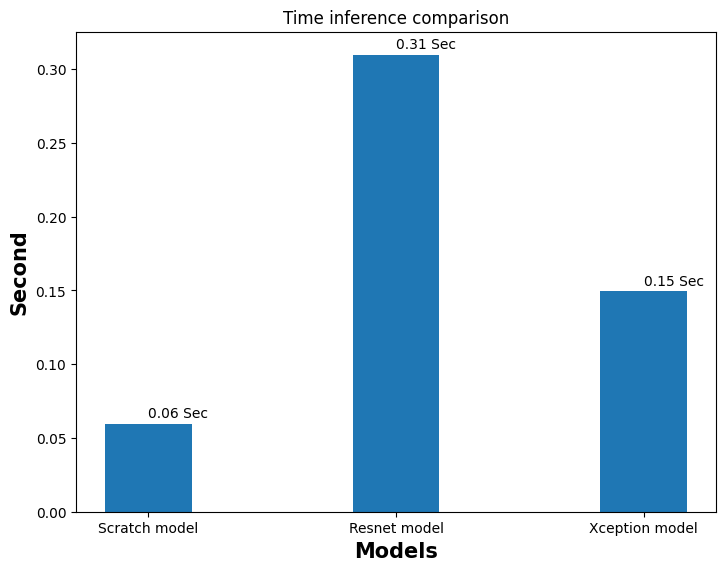

In [16]:
predict_times = models_predict_time.values()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Time inference comparison')
ax.bar(models_predict_time.keys(), predict_times, 0.35)
ax.set_xlabel('Models', fontweight ='bold', fontsize = 15)
ax.set_ylabel('Second', fontweight ='bold', fontsize = 15)

y_values = list(predict_times)
for i in range(len(y_values)):
    plt.text(i, y_values[i] + 0.004, str(round(y_values[i], 2)) + ' Sec')

plt.show()